In [ ]:
! pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Libraries initialization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.stats

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dataset initialization
path_to_file = 'https://raw.githubusercontent.com/RazinAleksandr/M-M-MSA-ITMO/main/Datasets/covid_19.csv'
source_df = pd.read_csv(path_to_file)

# Used features and data preparation
source_df = source_df[ [   
    'systolic_blood_pressure', 
    'diastolic_blood_pressure', 
    'heart_rate',
    'highest_heart_rate',
    'lowest_heart_rate', 
    'lowest_urine_output',
    'highest_ph',
    'hematocrit',
    'platelet_count',
    'potassium',
    'lowest_mean_arterial_pressure',
    'highest_mean_arterial_pressure',
    'temperature'
           ] ]

source_df.head(5)

,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,highest_heart_rate,lowest_heart_rate,lowest_urine_output,highest_ph,hematocrit,platelet_count,potassium,lowest_mean_arterial_pressure,highest_mean_arterial_pressure,temperature
0,119.0,54.0,79.0,80.0,73.0,700.0,NaN,0.354,116.0,4.1,85.0,85.0,37.2
1,133.0,64.0,73.0,73.0,69.0,1351.0,NaN,0.359,117.0,3.7,NaN,NaN,37.1
2,140.0,74.0,70.0,72.0,65.0,1420.0,NaN,0.372,145.0,4.0,NaN,NaN,37.5
3,154.0,78.0,77.0,80.0,72.0,350.0,NaN,0.383,218.0,3.9,NaN,NaN,37.1
4,155.0,61.0,64.0,77.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7


In [ ]:
print(source_df.dtypes)
print(' ')
print(source_df.isna().sum())

systolic_blood_pressure           float64
diastolic_blood_pressure          float64
heart_rate                        float64
highest_heart_rate                float64
lowest_heart_rate                 float64
lowest_urine_output               float64
highest_ph                        float64
hematocrit                        float64
platelet_count                    float64
potassium                         float64
lowest_mean_arterial_pressure     float64
highest_mean_arterial_pressure    float64
temperature                       float64
dtype: object
 
systolic_blood_pressure            975
diastolic_blood_pressure           975
heart_rate                         958
highest_heart_rate                 958
lowest_heart_rate                  958
lowest_urine_output               3186
highest_ph                        3748
hematocrit                        2321
platelet_count                    2326
potassium                         2364
lowest_mean_arterial_pressure     3297
highest_m

In [ ]:
# Some data cleaning
source_df.dropna(thresh=2000, axis=1, inplace=True)
source_df.fillna(source_df.median(), inplace=True)

In [ ]:
# Clean outliers
def out_clean(df):
    for column in df.columns.to_list():    
        # clean outliers
        # IQR
        Q1 = np.percentile(df[column], 25, interpolation='midpoint')
        Q3 = np.percentile(df[column], 75, interpolation='midpoint')
        IQR = Q3 - Q1

        # Upper bound
        upper = np.where(df[column] >= (Q3+1.5*IQR))
        # Lower bound
        lower = np.where(df[column] <= (Q1-1.5*IQR))

        ''' Removing the Outliers '''
        df.drop(upper[0], inplace = True)
        df.drop(lower[0], inplace = True)
        df.reset_index(drop=True, inplace=True)
    return df

print(f'Shape before: {source_df.shape}')
source_df = out_clean(source_df)
print(f'Shape after: {source_df.shape}')

Shape before: (4064, 6)
Shape after: (2171, 6)


In [ ]:
print(source_df.dtypes)
print(' ')
print(source_df.isna().sum())

systolic_blood_pressure     float64
diastolic_blood_pressure    float64
heart_rate                  float64
highest_heart_rate          float64
lowest_heart_rate           float64
temperature                 float64
dtype: object
 
systolic_blood_pressure     0
diastolic_blood_pressure    0
heart_rate                  0
highest_heart_rate          0
lowest_heart_rate           0
temperature                 0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Train Test split
train, test = train_test_split(source_df, test_size=0.2, random_state=10, shuffle=True)
print(train.shape, test.shape)

(1736, 6) (435, 6)


## Exercise №4

Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [ ]:
def create_edges(connections):

    edges = []
    for outlet, inlet in connections.items():
        for inl in inlet:
            edges.append([outlet, inl])
  
    return edges

connections = {
    'temperature': [],
    'diastolic_blood_pressure': ['temperature'],
    'systolic_blood_pressure': ['temperature', 'diastolic_blood_pressure'],
    'highest_heart_rate': ['systolic_blood_pressure','temperature'],
    'lowest_heart_rate': ['highest_heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'temperature'],
    'heart_rate': ['temperature', 'highest_heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'lowest_heart_rate'], 

}

edges = create_edges(connections)
vertices = ['temperature', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'highest_heart_rate', 'lowest_heart_rate']
bn = {"V":vertices, "E":edges}


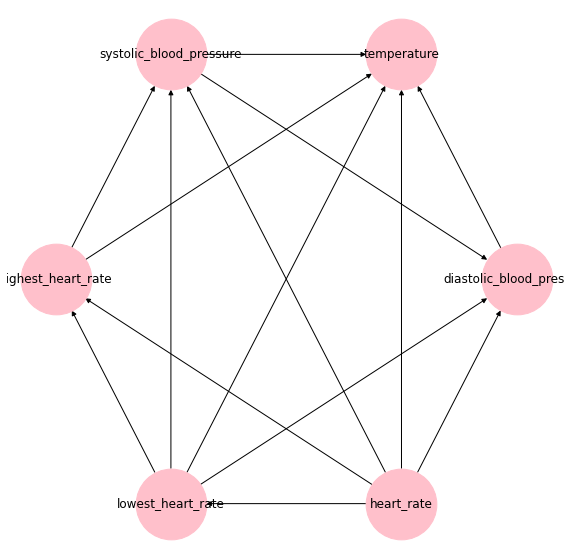

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(BayesianModel(edges).edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='pink', node_size=5000)

plt.show()

In [ ]:
df_transformed = source_df.copy()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(source_df.values[:])
df_transformed[:] = df_discretized
df_transformed

,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,highest_heart_rate,lowest_heart_rate,temperature
0,8.0,2.0,1.0,3.0,2.0,4.0
1,8.0,5.0,1.0,1.0,2.0,6.0
2,9.0,4.0,5.0,3.0,7.0,1.0
3,5.0,8.0,3.0,2.0,6.0,4.0
4,4.0,4.0,4.0,5.0,5.0,4.0
...,...,...,...,...,...,...
2166,3.0,3.0,4.0,4.0,6.0,2.0
2167,2.0,3.0,2.0,2.0,4.0,1.0
2168,4.0,4.0,4.0,5.0,5.0,4.0
2169,4.0,4.0,4.0,5.0,5.0,4.0


In [ ]:
def accuracy_params_restoration(bn, data):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param].copy()
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element, show_progress=False)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

In [ ]:
hc_search = HillClimbSearch(data=df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

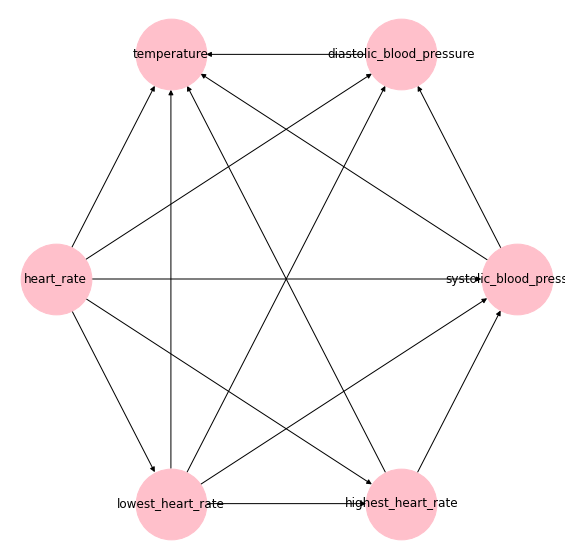

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='pink', node_size=5000)

plt.show()

In [ ]:
accuracy_params_restoration(BayesianNetwork(hc_k2.edges()),
                            df_transformed[:].sample(frac=0.01))

,Parameter,accuracy
0,systolic_blood_pressure,1.0
1,diastolic_blood_pressure,1.0
2,heart_rate,1.0
3,highest_heart_rate,1.0
4,lowest_heart_rate,1.0
5,temperature,1.0


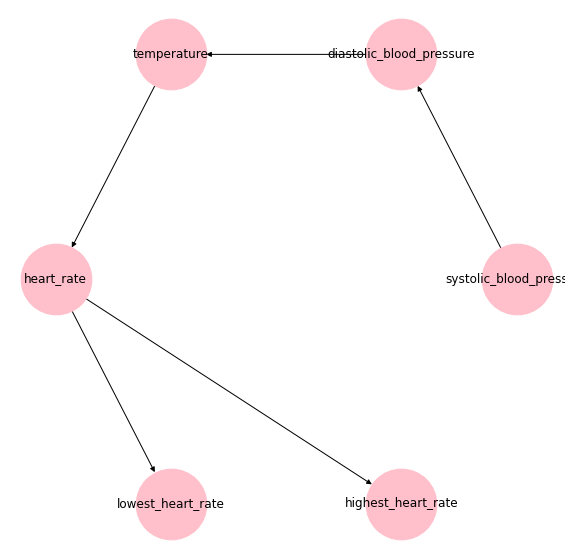

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='pink', node_size=5000)

plt.show()

In [ ]:
accuracy_params_restoration(BayesianNetwork(hc_bic.edges()),
                            df_transformed[:].sample(frac=0.01))

,Parameter,accuracy
0,systolic_blood_pressure,0.818182
1,diastolic_blood_pressure,1.0
2,heart_rate,0.954545
3,highest_heart_rate,0.818182
4,lowest_heart_rate,0.863636
5,temperature,0.909091


In [ ]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

Building tree:   0%|          | 0/15.0 [00:00<?, ?it/s]

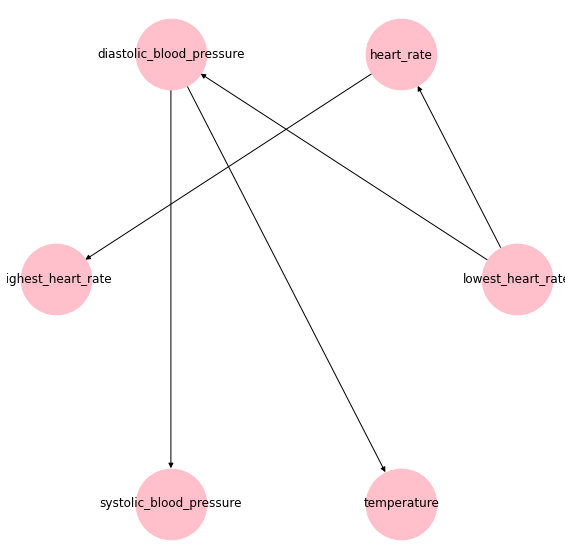

In [ ]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='pink', node_size=5000)

plt.show()

In [ ]:
def sampling (bn, data, n):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [ ]:
def draw_comparative_hist (parametr, original_data, data_sampled, axes=None):
    final_df = pd.DataFrame()
    
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    
    sns.barplot(ax=axes, x=parametr, y="Probability", hue="Data", data=final_df, palette='Reds')

In [ ]:
sample_K2 = sampling(hc_k2, df_transformed, df_transformed.shape[0])
sample_Bic = sampling(hc_bic, df_transformed, df_transformed.shape[0])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(classification_report(df_transformed.lowest_heart_rate, sample_K2.lowest_heart_rate))

              precision    recall  f1-score   support

         0.0       0.04      0.05      0.05        94
         1.0       0.02      0.02      0.02       127
         2.0       0.06      0.07      0.06       151
         3.0       0.08      0.09      0.08       128
         4.0       0.12      0.11      0.12        96
         5.0       0.51      0.50      0.50      1107
         6.0       0.06      0.06      0.06       158
         7.0       0.07      0.06      0.06       116
         8.0       0.08      0.08      0.08       129
         9.0       0.00      0.00      0.00        65

    accuracy                           0.28      2171
   macro avg       0.10      0.10      0.10      2171
weighted avg       0.29      0.28      0.29      2171



In [ ]:
print(classification_report(df_transformed.lowest_heart_rate, sample_Bic.lowest_heart_rate))

              precision    recall  f1-score   support

         0.0       0.08      0.09      0.08        94
         1.0       0.03      0.03      0.03       127
         2.0       0.05      0.05      0.05       151
         3.0       0.07      0.06      0.06       128
         4.0       0.07      0.07      0.07        96
         5.0       0.52      0.55      0.54      1107
         6.0       0.05      0.05      0.05       158
         7.0       0.04      0.04      0.04       116
         8.0       0.10      0.09      0.09       129
         9.0       0.00      0.00      0.00        65

    accuracy                           0.31      2171
   macro avg       0.10      0.10      0.10      2171
weighted avg       0.29      0.31      0.30      2171



In [ ]:
print(classification_report(df_transformed.temperature, sample_K2.temperature))

              precision    recall  f1-score   support

         0.0       0.10      0.09      0.09       167
         1.0       0.08      0.08      0.08       193
         2.0       0.10      0.10      0.10       209
         4.0       0.53      0.52      0.53      1159
         5.0       0.06      0.06      0.06       173
         6.0       0.06      0.07      0.06       145
         7.0       0.05      0.06      0.06       125

    accuracy                           0.31      2171
   macro avg       0.14      0.14      0.14      2171
weighted avg       0.32      0.31      0.32      2171



In [ ]:
print(classification_report(df_transformed.temperature, sample_Bic.temperature))

              precision    recall  f1-score   support

         0.0       0.09      0.09      0.09       167
         1.0       0.11      0.12      0.12       193
         2.0       0.10      0.09      0.09       209
         4.0       0.53      0.53      0.53      1159
         5.0       0.09      0.08      0.08       173
         6.0       0.06      0.06      0.06       145
         7.0       0.03      0.02      0.03       125

    accuracy                           0.32      2171
   macro avg       0.14      0.14      0.14      2171
weighted avg       0.32      0.32      0.32      2171



In [ ]:
print(classification_report(df_transformed.highest_heart_rate, sample_K2.highest_heart_rate))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        90
         1.0       0.00      0.00      0.00        84
         2.0       0.10      0.10      0.10       130
         3.0       0.12      0.12      0.12       226
         4.0       0.07      0.08      0.07       142
         5.0       0.53      0.50      0.51      1127
         6.0       0.06      0.06      0.06       164
         7.0       0.08      0.08      0.08       102
         8.0       0.03      0.03      0.03        73
         9.0       0.00      0.00      0.00        33

    accuracy                           0.29      2171
   macro avg       0.10      0.10      0.10      2171
weighted avg       0.30      0.29      0.30      2171



In [ ]:
print(classification_report(df_transformed.highest_heart_rate, sample_Bic.highest_heart_rate))

              precision    recall  f1-score   support

         0.0       0.04      0.04      0.04        90
         1.0       0.03      0.02      0.02        84
         2.0       0.04      0.04      0.04       130
         3.0       0.11      0.11      0.11       226
         4.0       0.04      0.04      0.04       142
         5.0       0.53      0.56      0.55      1127
         6.0       0.05      0.04      0.04       164
         7.0       0.02      0.02      0.02       102
         8.0       0.02      0.01      0.02        73
         9.0       0.03      0.03      0.03        33

    accuracy                           0.31      2171
   macro avg       0.09      0.09      0.09      2171
weighted avg       0.30      0.31      0.31      2171



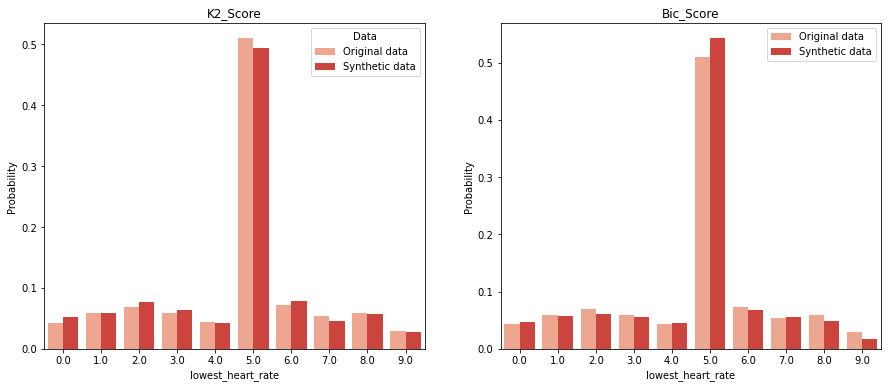

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('lowest_heart_rate', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('lowest_heart_rate', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

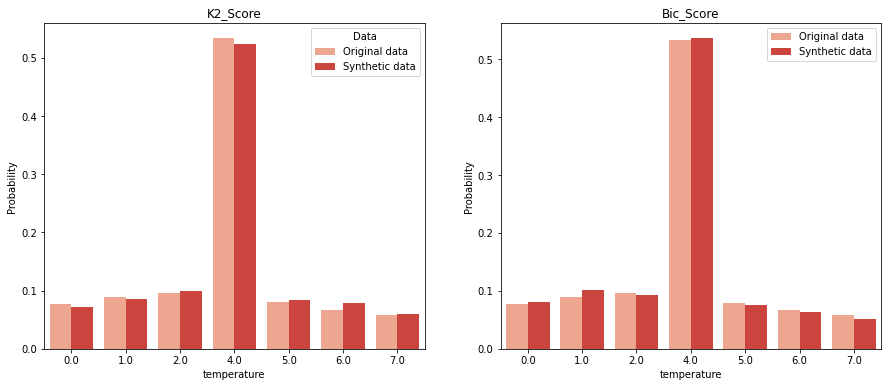

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('temperature', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('temperature', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

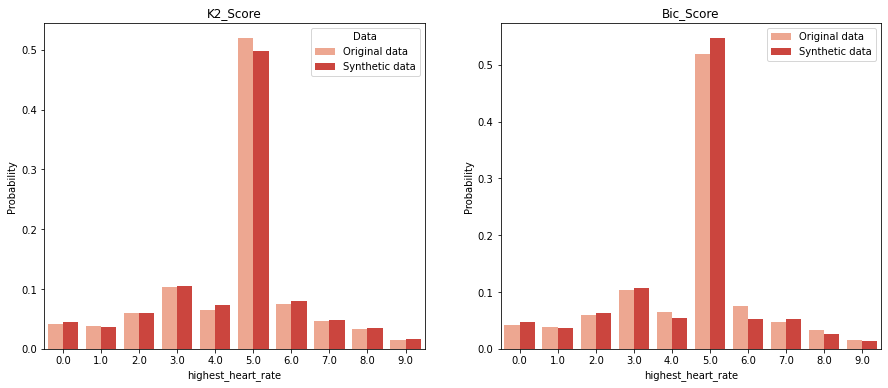

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

draw_comparative_hist('highest_heart_rate', df_transformed, sample_K2, axes=axes[0])
draw_comparative_hist('highest_heart_rate', df_transformed, sample_Bic, axes=axes[1])

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

In [ ]:
# scaler = StandardScaler()
# sample_K2[sample_K2.columns] = scaler.fit_transform(sample_K2[sample_K2.columns].values)
# sample_Bic[sample_Bic.columns] = scaler.fit_transform(sample_Bic[sample_Bic.columns].values)
# sample_K2[sample_K2.columns] = scaler.inverse_transform(sample_K2[sample_K2.columns].values)
# sample_Bic[sample_Bic.columns] = scaler.inverse_transform(sample_Bic[sample_Bic.columns].values)

In [ ]:
sample_K2.columns = ['1', '2', '3', '4', '5', '6']
sample_Bic.columns = ['1', '2', '3', '4', '5', '6']

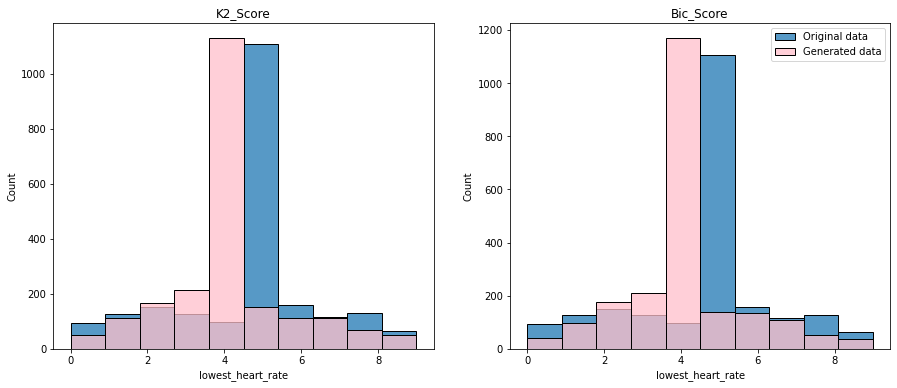

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_transformed['lowest_heart_rate'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['1'], label='Generated data', color='pink', ax=axes[0], bins=10)

sns.histplot(df_transformed['lowest_heart_rate'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['1'], label='Generated data', color='pink', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

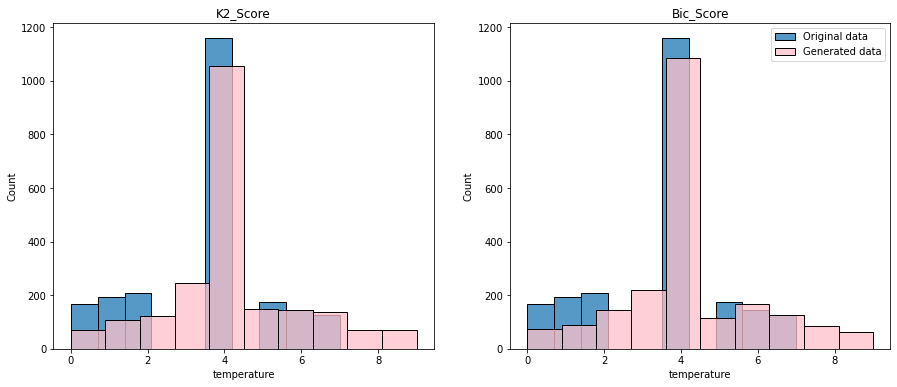

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_transformed['temperature'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['2'], label='Generated data', color='pink', ax=axes[0], bins=10)

sns.histplot(df_transformed['temperature'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['2'], label='Generated data', color='pink', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()

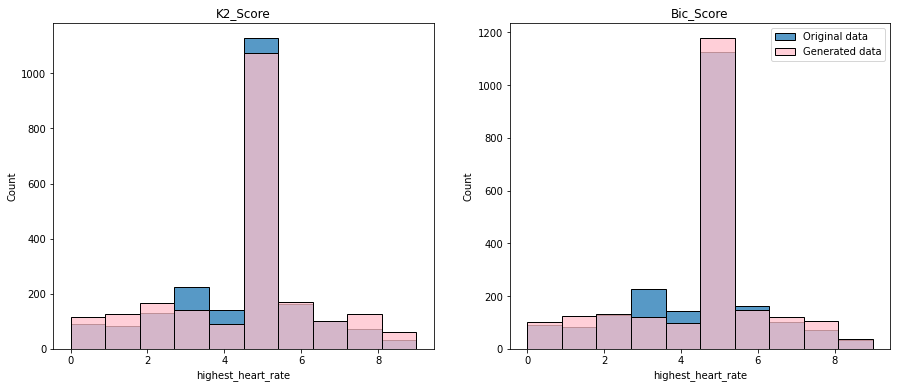

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df_transformed['highest_heart_rate'], label='Original data', ax=axes[0], bins=10)
sns.histplot(sample_K2['5'], label='Generated data', color='pink', ax=axes[0], bins=10)

sns.histplot(df_transformed['highest_heart_rate'], label='Original data', ax=axes[1], bins=10)
sns.histplot(sample_Bic['5'], label='Generated data', color='pink', ax=axes[1], bins=10)

axes[0].set_title('K2_Score')
axes[1].set_title('Bic_Score')
plt.legend()
plt.show()